In [47]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
from math import sqrt
from calendar import monthrange

import matplotlib.dates as mdates
import matplotlib.pyplot as plt                  # plots
#import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

### Parameters

In [6]:
file_path = '../data/bike_sharing_data/day.csv'

# Building a LSTM Network

## 0) Load & pre-process the data

In [7]:
df = pd.read_csv(file_path, index_col=['dteday'], parse_dates=['dteday'])
# drop the `instant` col, which is just a row counter
df = df.drop('instant', 1)

In [8]:
# Add columns with year, month, and weekday name
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Weekday Name'] = df.index.weekday_name

In [9]:
print("Dimensions of the data: ", df.shape)
df.head()

Dimensions of the data:  (731, 17)


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,Year,Month,Weekday Name
dteday,,,,,,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,2011,1,Saturday
2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,2011,1,Sunday
2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,2011,1,Monday
2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,2011,1,Tuesday
2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,2011,1,Wednesday


## 1) Visualize trends in continuous data

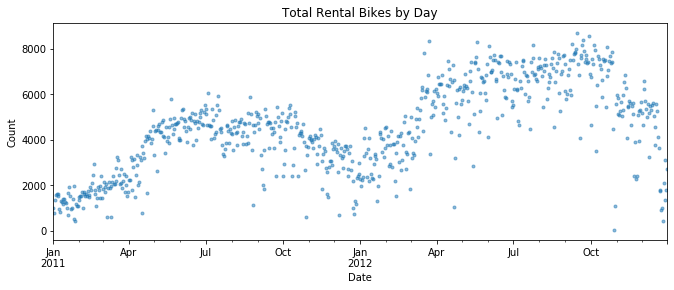

In [11]:
# larger visualization of just total bike rentals
df['cnt'].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 4))

plt.title("Total Rental Bikes by Day")
plt.xlabel("Date")
plt.ylabel("Count")
plt.show()

## 2) Basic case: 1 train & test split
Predict the bike rental counts in the last 30 days after training on all days prior to the last 30 days.

#### Helper functions

In [35]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# transform train & test data to [-1 and 1]
    # the scale of the activation function for LSTMs
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
    
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

#### Fit the model

In [33]:
# extract just the count data as a pandas series
rental_count = df['cnt']

# transform data to be stationary
raw_values = rental_count.values
diff_values = difference(raw_values, 1)

# transform data to a supervised learning setup
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-30], supervised_values[-30:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[ 1.89169198e-01],
       [ 1.90694600e-01],
       [ 1.08325787e-01],
       [ 7.67268538e-02],
       [ 7.29076713e-02],
       [ 6.70973435e-02],
       [ 7.69817978e-02],
       [ 1.12105079e-01],
       [ 9.53339562e-02],
       [ 8.07465985e-02],
       [ 1.05187774e-01],
       [ 7.50484392e-02],
       [ 5.36054149e-02],
       [ 5.48996776e-02],
       [ 9.78556648e-02],
       [ 7.17013851e-02],
       [ 1.01630464e-01],
       [ 9.98182297e-02],
       [ 6.23929054e-02],
       [ 5.48414588e-02],
       [ 9.91640911e-02],
       [ 1.27485156e-01],
       [ 8.50484967e-02],
       [ 7.50789642e-02],
       [ 2.80126780e-02],
       [ 2.48900682e-01],
       [ 1.29729807e-01],
       [ 1.53562948e-01],
       [ 1.11575037e-01],
       [ 1.27253711e-01],
       [ 8.27185735e-02],
       [ 1.03450954e-01],
       [ 8.21618438e-02],
       [ 9.49228033e-02],
       [ 8.69335234e-02],
       [ 1.98286206e-01],
       [ 1.15177304e-01],
       [ 1.35971114e-01],
       [ 1.1

#### Predict bike rental counts for each day in the test set one at a time

In [36]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Day=1, Predicted=4379.891936, Expected=4649.000000
Day=2, Predicted=4062.806639, Expected=6234.000000
Day=3, Predicted=5367.198402, Expected=6606.000000
Day=4, Predicted=5726.029625, Expected=5729.000000
Day=5, Predicted=4770.525872, Expected=5375.000000
Day=6, Predicted=4564.840674, Expected=5008.000000
Day=7, Predicted=4411.636261, Expected=5582.000000
Day=8, Predicted=4951.726053, Expected=3228.000000
Day=9, Predicted=4612.837847, Expected=5170.000000
Day=10, Predicted=4553.079943, Expected=5501.000000
Day=11, Predicted=5349.968818, Expected=5319.000000
Day=12, Predicted=4829.284739, Expected=5532.000000
Day=13, Predicted=4956.242534, Expected=5611.000000
Day=14, Predicted=5068.486173, Expected=5047.000000
Day=15, Predicted=4593.555054, Expected=3786.000000
Day=16, Predicted=4015.602816, Expected=4585.000000
Day=17, Predicted=4284.190444, Expected=5557.000000
Day=18, Predicted=5377.762890, Expected=5267.000000
Day=19, Predicted=4849.564577, Expected=4128.000000
Day=20, Predicted=403

Test RMSE: 1099.442


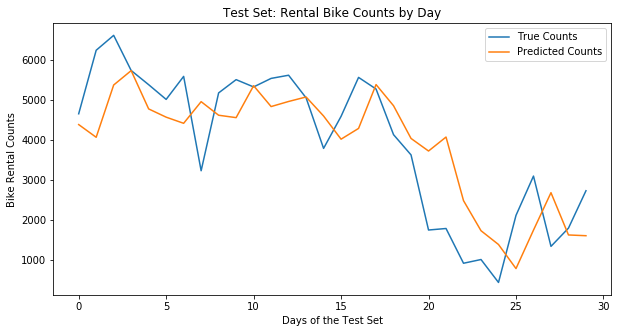

In [44]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-30:], predictions))
print('Test RMSE: %.3f' % rmse)

# line plot of observed vs predicted
plt.figure(figsize=(10, 5))
plt.plot(raw_values[-30:], label="True Counts")
plt.plot(predictions, label="Predicted Counts")

plt.title("Test Set: Rental Bike Counts by Day")
plt.xlabel('Days of the Test Set')
plt.ylabel('Bike Rental Counts')
plt.legend()
plt.show()

## 3) Using walk-forward validation to backtest our model

If we wanted to get a sense of RMSE/MSE at multiple points in time. 

*Note: I didn't run the code below because just training one LSTM above already took a really long time (somewhere around 30 minutes - 1 hr on my laptop). The below would train and test 12 LSTMs, so I want to see if it's worth running in its entirety before actually kicking it off. Basically, the walk-forward validation framework first uses 1 year of bike rental data (i.e., 2011 data) to predict for January 2012, then it uses 2011 + Jan 2012 to predict Feb 2012, and so on...*

We should be able to plug in other forecasting models (e.g., arima/sarima) into this framework too and backtest their performance.

In [60]:
def transform_and_fit(raw_values, test_days):
    diff_values = difference(raw_values, 1)

    # transform data to a supervised learning setup
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values

    # split data into train and test-sets
    train, test = supervised_values[0:-(test_days-1)], supervised_values[-(test_days-1):]

    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)

    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    
    return lstm_model

Test RMSE: 840.901


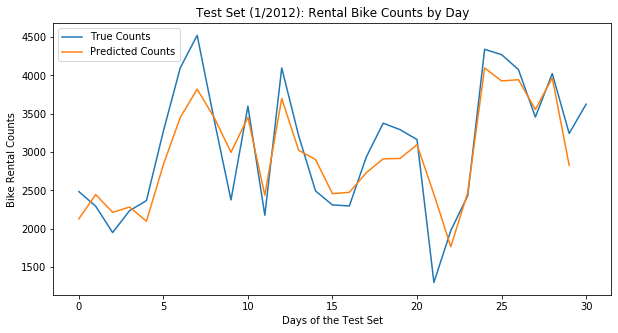

Test RMSE: 990.856


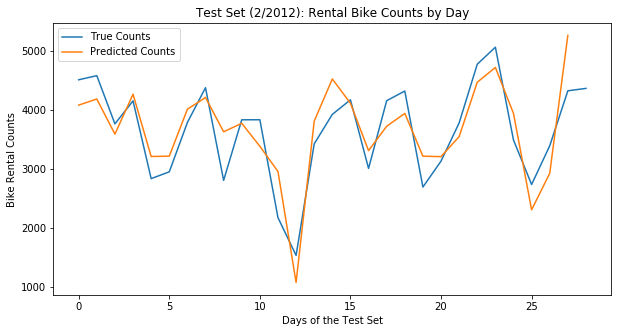

Test RMSE: 1334.666


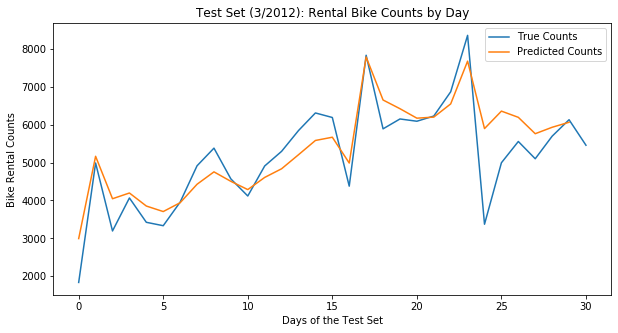

Test RMSE: 1406.852


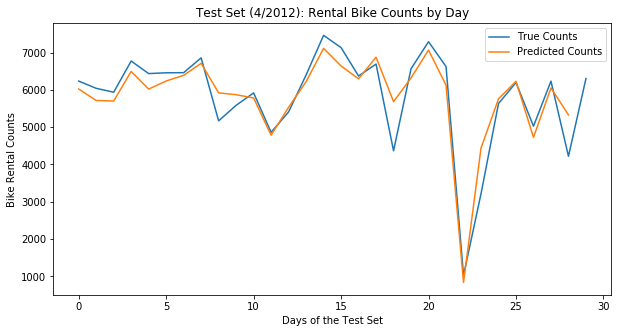

Test RMSE: 1380.277


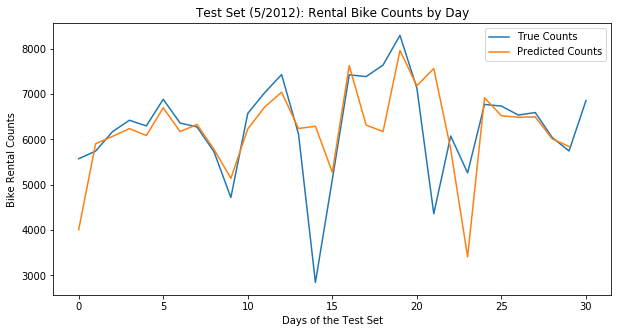

Test RMSE: 1044.069


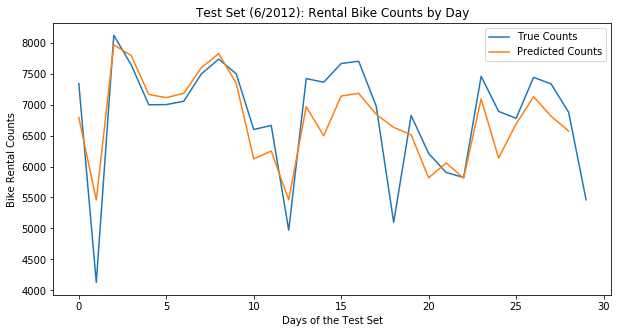

Test RMSE: 930.265


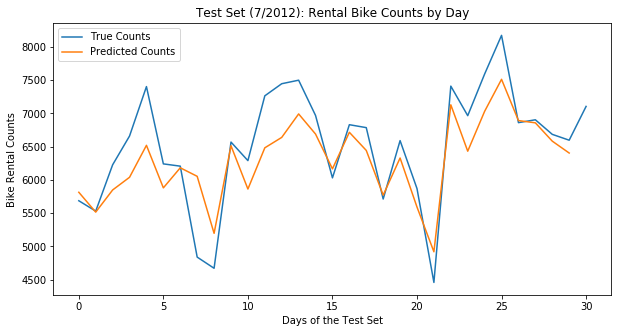

Test RMSE: 924.478


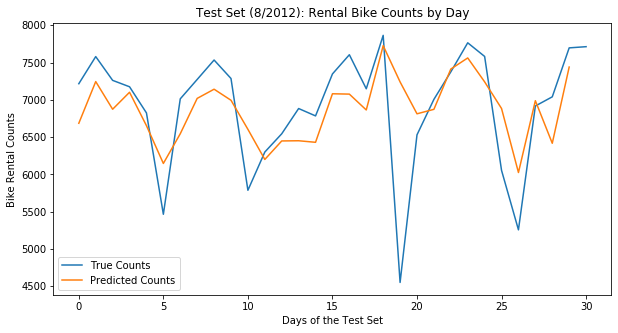

Test RMSE: 1172.303


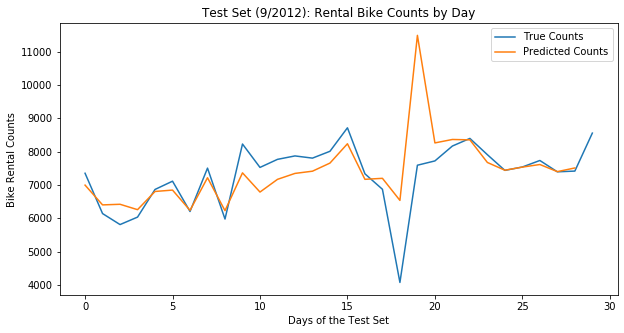

Test RMSE: 1766.731


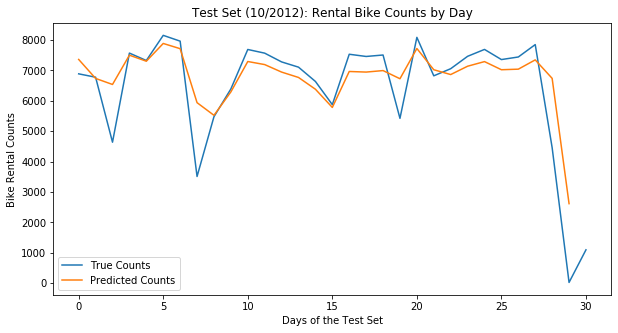

Test RMSE: 1143.752


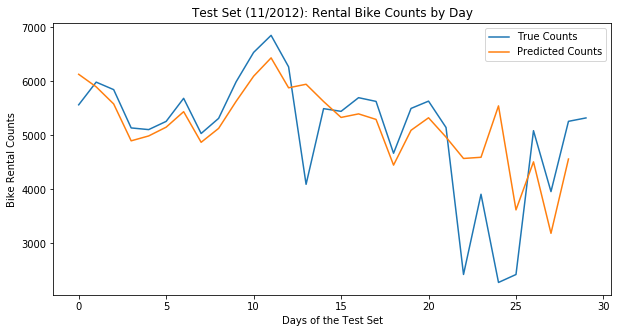

Test RMSE: 997.853


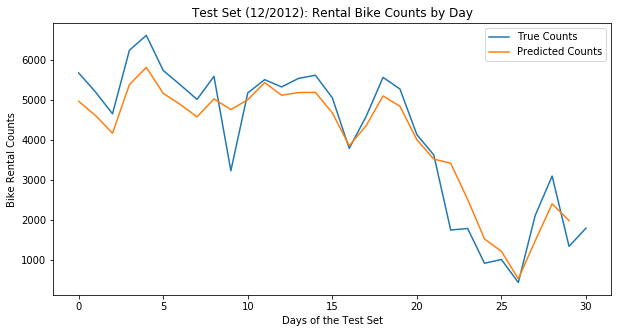

In [61]:
# how many days to use in the training set initially
days = 364 
# to store the models' predictions
predicted_dict = {}
all_rmse = []

# iterate through the 12 months of 2012
for i in range(1, 13):
    # get the # of days in the month of interest
    test_days = monthrange(2012, i)[1]
    # add it to the days used for training
    days += test_days 
    # isolate just the train and test data
    raw_values = rental_count[:days].values
    
    # transform data to be stationary
    diff_values = difference(raw_values, 1)

    # transform data to a supervised learning setup
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values

    # split data into train and test-sets
    train, test = supervised_values[0:-(test_days-1)], supervised_values[-(test_days-1):]

    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)

    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    
    # walk-forward validation on the test data
    predictions = list()
    for j in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[j, 0:-1], test_scaled[j, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-j)
        # store forecast
        predictions.append(yhat)
    # store predictions    
    predicted_dict[i] = predictions
    
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-(test_days-1):], predictions))
    print('Test RMSE: %.3f' % rmse)
    all_rmse.append(rmse)
    
    # line plot of observed vs predicted
    plt.figure(figsize=(10, 5))
    plt.plot(raw_values[-test_days:], label="True Counts")
    plt.plot(predictions, label="Predicted Counts")
    plt.title("Test Set ({i}/2012): Rental Bike Counts by Day".format(i=i))
    plt.xlabel('Days of the Test Set')
    plt.ylabel('Bike Rental Counts')
    plt.legend()
    plt.show()

In [65]:
# all RMSE across all months
all_rmse

[840.9005324250124,
 990.8557535763698,
 1334.665712320402,
 1406.8518923309402,
 1380.2771423549982,
 1044.0687469600507,
 930.265372654311,
 924.4777415804213,
 1172.3026541955646,
 1766.7306380399284,
 1143.752369375326,
 997.8531676059287]

In [68]:
# average RMSE
np.mean(all_rmse)

1161.0834769516043